In [1]:
import jax
import jax.numpy as jnp
import scipy
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp
from toolz import partial, valmap
from tqdm.auto import tqdm
from aging.plotting import figure, format_plots, add_identity, legend
from aging.behavior.bio_age_model import (
    age_normalizer_factory,
    neg_log_likelihood,
    create_splines,
    optimize,
    get_biological_age,
    get_biological_age_v2,
    neg_log_likelihood_v2,
    neg_log_likelihood_v3,
    fit_params,
    fit_params_v2,
    create_masks, 
    compute_local_derivative,
    compute_local_derivative_v2,

)
from sklearn.model_selection import StratifiedShuffleSplit
from itertools import product

In [2]:
warnings.simplefilter("ignore")

In [3]:
format_plots()

In [4]:
df = pd.read_parquet(
    # "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_counts_matrix_v00.parquet"
    "/Users/wingillis/Dropbox (HMS)/ontogeny-data/ontogeny_males_relabeled_counts_matrix_v00.parquet"
)
df = df.sort_index(axis=1)

n_syllables = 55
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))[:, :n_syllables]

In [5]:
df.head()

0   \
age mouse    subject_name session_name uuid                                 date                         
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30  106.0   
    4M_01_02 4M_01_02     otgy_4M_01   2bb5e7fa-02cd-4694-accf-fed9651b1beb 2023-12-01 08:00:22  112.0   
    4M_01_03 4M_01_03     otgy_4M_01   7daed982-62e5-4695-971f-c229381d7521 2023-12-01 11:04:03  114.0   
    4M_01_04 4M_01_04     otgy_4M_01   43e12fcc-2119-4e15-b11c-add440ca5f74 2023-12-01 07:51:47  108.0   
    4M_02_01 4M_02_01     otgy_4M_02   6568fdb5-82b5-4241-8ccb-572ae49bd87a 2023-12-01 12:53:09   67.0   

                                                                                                    1   \
age mouse    subject_name session_name uuid                                 date                         
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30  413.0   
    4M_01_02 4M_01_02     otgy_4M_01   2bb5e7fa-02cd-4694-accf-fed9651b1beb 2023-12-01 08:00:22  417.0   
    4M_01_03 4M_01_03     otgy_4M_01   7daed982-62e5-4695-971f-c229381d7521 2023-12-01 11:04:03  454.0   
    4M_01_04 4M_01_04     otgy_4M_01   43e12fcc-2119-4e15-b11c-add440ca5f74 2023-12-01 07:51:47  332.0   
    4M_02_01 4M_02_01     otgy_4M_02   6568fdb5-82b5-4241-8ccb-572ae49bd87a 2023-12-01 12:53:09  491.0   

                                                                                                    2   \
age mouse    subject_name session_name uuid                                 date                         
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30  144.0   
    4M_01_02 4M_01_02     otgy_4M_01   2bb5e7fa-02cd-4694-accf-fed9651b1beb 2023-12-01 08:00:22  179.0   
    4M_01_03 4M_01_03     otgy_4M_01   7daed982-62e5-4695-971f-c229381d7521 2023-12-01 11:04:03  135.0   
    4M_01_04 4M_01_04     otgy_4M_01   43e12fcc-2119-4e15-b11c-add440ca5f74 2023-12-01 07:51:47  198.0   
    4M_02_01 4M_02_01     otgy_4M_02   6568fdb5-82b5-4241-8ccb-572ae49bd87a 2023-12-01 12:53:09  167.0   

                                                                                                   3   \
age mouse    subject_name session_name uuid                                 date                        
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30  92.0   
    4M_01_02 4M_01_02     otgy_4M_01   2bb5e7fa-02cd-4694-accf-fed9651b1beb 2023-12-01 08:00:22  72.0   
    4M_01_03 4M_01_03     otgy_4M_01   7daed982-62e5-4695-971f-c229381d7521 2023-12-01 11:04:03  74.0   
    4M_01_04 4M_01_04     otgy_4M_01   43e12fcc-2119-4e15-b11c-add440ca5f74 2023-12-01 07:51:47  37.0   
    4M_02_01 4M_02_01     otgy_4M_02   6568fdb5-82b5-4241-8ccb-572ae49bd87a 2023-12-01 12:53:09  40.0   

                                                                                                    4   \
age mouse    subject_name session_name uuid                                 date                         
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30   76.0   
    4M_01_02 4M_01_02     otgy_4M_01   2bb5e7fa-02cd-4694-accf-fed9651b1beb 2023-12-01 08:00:22   70.0   
    4M_01_03 4M_01_03     otgy_4M_01   7daed982-62e5-4695-971f-c229381d7521 2023-12-01 11:04:03   41.0   
    4M_01_04 4M_01_04     otgy_4M_01   43e12fcc-2119-4e15-b11c-add440ca5f74 2023-12-01 07:51:47  101.0   
    4M_02_01 4M_02_01     otgy_4M_02   6568fdb5-82b5-4241-8ccb-572ae49bd87a 2023-12-01 12:53:09   72.0   

                                                                                                    5   \
age mouse    subject_name session_name uuid                                 date                         
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30  111.0   
    4M_01_02 4M_01_02     otgy_4M_01   2bb5e7fa-02cd-4694-accf-fed9651b1be

## Run held-out fitting to determine number of splines

In [12]:
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 500)
age_sd = age_normalizer(10)

keep_syllables = 15
n_sessions = len(syllable_counts_jax)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 0.3,
}

pbar = tqdm(range(4, 10, 1))

out_ll = {}

for n_splines in pbar:
    rng = np.random.RandomState(3)
    spline_class, splines = create_splines(age_samples, df=n_splines)

    params = fit_params(syllable_counts_jax, n_splines, age, age_samples, age_normalizer, n_syllables)

    lls = []
    for i in range(4):
        hypparams["mask"], hypparams["heldout_mask"] = create_masks(keep_syllables, n_syllables, n_sessions, rng)
        ll_fun = partial(
            neg_log_likelihood,
            bases=splines,
            age_samples=age_samples,
            true_age=age_normalizer(age),
            counts=syllable_counts_jax + 1,
            hypparams=hypparams,
            heldout=False,
        )
        optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=40)

        heldout_nll = neg_log_likelihood(
            optimized_params,
            splines,
            age_samples,
            age_normalizer(age),
            syllable_counts_jax + 1,
            hypparams=hypparams,
            heldout=True,
        )
        out_ll[(n_splines, i)] = -heldout_nll
        lls.append(-heldout_nll)

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
heldout_ll_df = (
    pd.DataFrame(valmap(lambda v: v.item(), out_ll), index=[0])
    .rename_axis(["n_splines", "fold"], axis=1)
    .melt(value_name="log_likelihood")
)

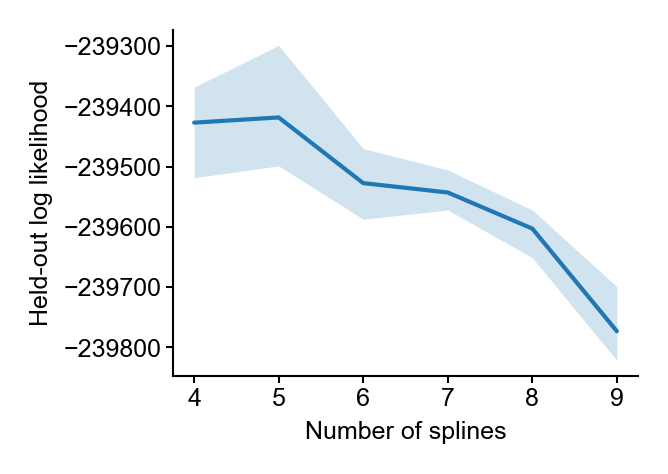

In [14]:
fig = figure(2, 1.5)
ax = sns.lineplot(data=heldout_ll_df, x="n_splines", y="log_likelihood", err_kws=dict(lw=0))
ax.set(xlabel="Number of splines", ylabel="Held-out log likelihood")
sns.despine()

In [15]:
heldout_ll_df.groupby("n_splines")["log_likelihood"].mean().sort_values(ascending=False)

n_splines
5   -239418.539062
4   -239427.199219
6   -239527.523438
7   -239543.039062
8   -239602.976562
9   -239773.183594
Name: log_likelihood, dtype: float64

In [12]:
bio_age = jnp.exp(optimized_params['basis_weights']) @ splines
distribution = tfp.distributions.DirichletMultinomial(
    total_count=syllable_counts_jax.sum(axis=1)[:, None],
    concentration=jnp.swapaxes(bio_age[:, ::4][None], 1, 2)
)
syllable_samples = distribution.sample(seed=jax.random.PRNGKey(0))

bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

In [ ]:
plot_syllables = 6
x = age_unnormalizer(age_samples[::4])

fig, ax = plt.subplots(
    plot_syllables, 2, figsize=(3.25, 1.2 * plot_syllables), sharex=True, sharey=False
)
for syllable in range(plot_syllables):
    avg_sample = syllable_samples[..., syllable].mean(0)
    a = ax[syllable, 0]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        age, syllable_counts_jax[:, syllable], "o", label="Data", alpha=0.6, mew=0, ms=3
    )
    a.set(title=f"Syllable {syllable}", xlabel="Age (weeks)", ylabel="Syllable counts")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
    a = ax[syllable, 1]
    a.plot(x, avg_sample, label="Model fit")
    a.plot(
        bio_ages,
        syllable_counts_jax[:, syllable],
        "o",
        label="Bio ages",
        alpha=0.6,
        mew=0,
        ms=3,
        c="C2",
    )
    a.set(xlabel="Biological age (weeks)")
    l = a.legend(fancybox=False)
    l.get_frame().set_linewidth(0)
sns.despine()
fig.tight_layout()

## Test feature importance code with just bio age

In [6]:
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
age_samples = np.linspace(0, 1, 500)
age_sd = age_normalizer(10)

hypparams = {
    "age_sd": age_sd,
    "params_sd": 0.3,
}
n_splines = 5

spline_class, splines = create_splines(age_samples, df=n_splines)
params = fit_params(syllable_counts_jax, n_splines, age, age_samples, age_normalizer, n_syllables)

# hypparams["mask"], hypparams["heldout_mask"] = create_masks(keep_syllables, n_syllables, n_sessions, rng)

ll_fun = partial(
    neg_log_likelihood,
    bases=splines,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=False,
)
optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=40)

heldout_nll = neg_log_likelihood(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=True,
)

In [7]:
bio_ages = get_biological_age(
    optimized_params,
    splines,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

In [17]:
local_d = compute_local_derivative(bio_ages, age_normalizer, optimized_params, n_splines)

Text(0, 0.5, 'syllables')

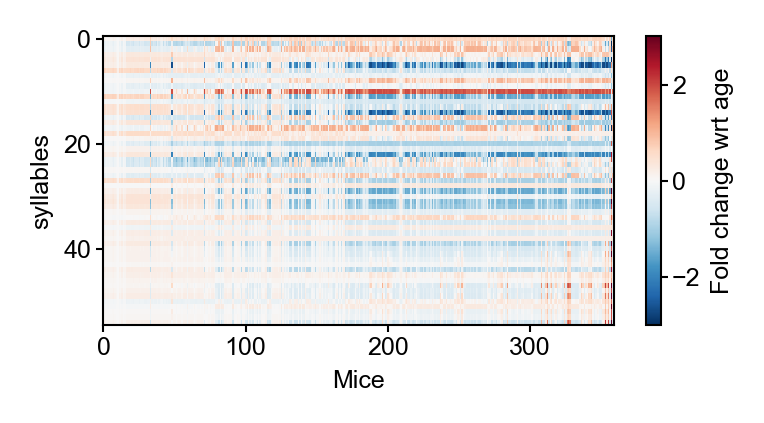

In [18]:
mag = 3
figure(2.75, 1.25)
plt.imshow(
    local_d.T, vmin=-mag, vmax=mag, cmap="RdBu_r", aspect="auto", interpolation="none"
)
plt.colorbar(label="Fold change wrt age")
plt.xlabel("Mice")
plt.ylabel("syllables")

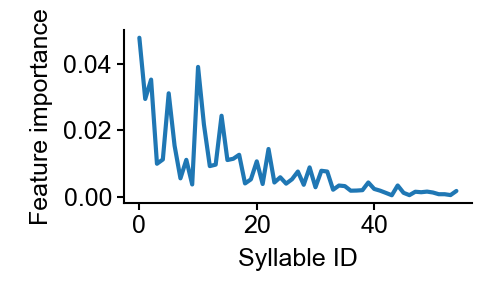

In [28]:
figure(1.5, 0.75)
plt.plot(np.median(np.abs(local_d), axis=0))
plt.ylabel("Feature importance")
plt.xlabel("Syllable ID")
sns.despine()

## Add mouse size into fitting procedure

In [7]:
# pth = '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet'
pth = '/Users/wingillis/Dropbox (HMS)/ontogeny-data/ontogeny_males_mouse_area_df_v00.parquet'
size_df = pd.read_parquet(pth)

In [8]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()

def demean(ser: pd.Series):
    return ser - ser.mean()

In [9]:
sizes_col = size_df.groupby('age')[0.5].transform(demean)
# sizes_col = size_df.groupby('age')[0.5].transform(zscore)
sizes_col = sizes_col.loc[df.index]

In [37]:
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
size_normalizer, size_unnormalizer = age_normalizer_factory(min_age=sizes_col.min(), max_age=sizes_col.max(), log_transform=False)
age_samples = np.linspace(0, 1, 500)
age_sd = age_normalizer(10)

keep_syllables = 15
n_sessions = len(syllable_counts_jax)

n_size_splines = 5

hypparams = {
    "age_sd": age_sd,
    "bio_params_sd": 0.3,
    "size_params_sd": 0.25,
}

# adding in size
sizes = size_normalizer(sizes_col.to_numpy())
spline_class, _ = create_splines(age_samples, df=n_size_splines)
size_splines = spline_class.transform(sizes).T

pbar = tqdm(range(4, 10, 1))

out_ll = {}

for n_splines in pbar:
    rng = np.random.RandomState(3)
    spline_class, splines = create_splines(age_samples, df=n_splines)

    params = fit_params_v2(syllable_counts_jax, n_splines, age, n_size_splines, n_syllables, age_samples, age_normalizer)

    basis_dict = {"bio": splines, "size": size_splines}

    lls = []
    for i in range(4):
        hypparams["mask"], hypparams["heldout_mask"] = create_masks(keep_syllables, n_syllables, n_sessions, rng)
        ll_fun = partial(
            neg_log_likelihood_v2,
            bases=basis_dict,
            age_samples=age_samples,
            true_age=age_normalizer(age),
            counts=syllable_counts_jax + 1,
            hypparams=hypparams,
            heldout=False,
        )
        optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=40)

        heldout_nll = neg_log_likelihood_v2(
            optimized_params,
            basis_dict,
            age_samples,
            age_normalizer(age),
            syllable_counts_jax + 1,
            hypparams=hypparams,
            heldout=True,
        )
        out_ll[(n_splines, i)] = -heldout_nll
        lls.append(-heldout_nll)

  0%|          | 0/6 [00:00<?, ?it/s]

In [38]:
size_heldout_ll_df = (
    pd.DataFrame(valmap(lambda v: v.item(), out_ll), index=[0])
    .rename_axis(["n_splines", "fold"], axis=1)
    .melt(value_name="log_likelihood")
)

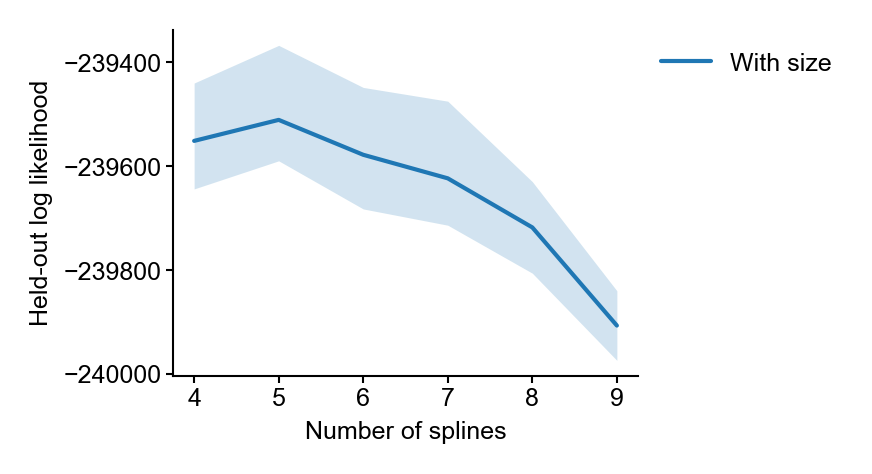

In [39]:
fig = figure(2, 1.5)
ax = sns.lineplot(
    data=size_heldout_ll_df,
    x="n_splines",
    y="log_likelihood",
    err_kws=dict(lw=0),
    label="With size",
)
ax.set(xlabel="Number of splines", ylabel="Held-out log likelihood")
legend()
sns.despine()

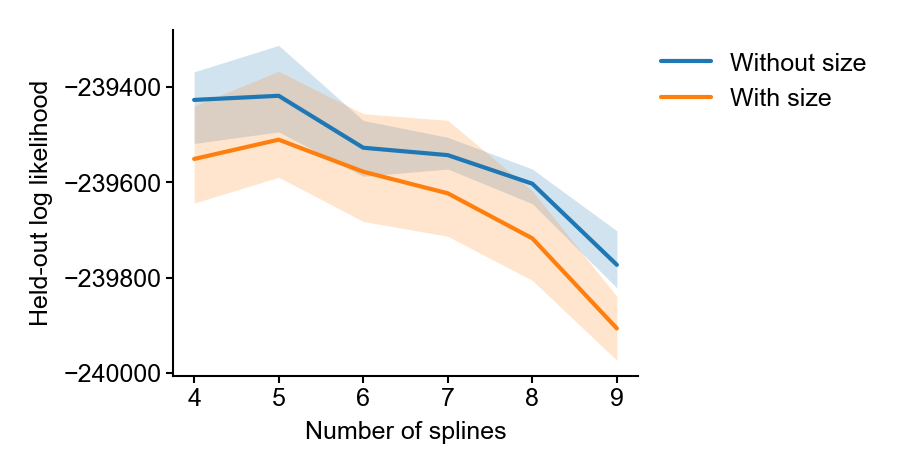

In [40]:
fig = figure(2, 1.5)
ax = sns.lineplot(
    data=heldout_ll_df,
    x="n_splines",
    y="log_likelihood",
    err_kws=dict(lw=0),
    label="Without size",
)
ax = sns.lineplot(
    data=size_heldout_ll_df,
    x="n_splines",
    y="log_likelihood",
    err_kws=dict(lw=0),
    label="With size",
)
ax.set(xlabel="Number of splines", ylabel="Held-out log likelihood")
legend()
sns.despine()

## Test feature importance code

In [10]:
use_log_age = False
age_normalizer, age_unnormalizer = age_normalizer_factory(
    min_age=1, max_age=130, log_transform=use_log_age
)
size_normalizer, size_unnormalizer = age_normalizer_factory(
    min_age=sizes_col.min(), max_age=sizes_col.max(), log_transform=False
)
age_samples = np.linspace(0, 1, 500)
age_sd = age_normalizer(10)

n_size_splines = 5
n_splines = 5

hypparams = {
    "age_sd": age_sd,
    "bio_params_sd": 0.3,
    "size_params_sd": 0.3,
}

# adding in size
sizes = size_normalizer(sizes_col.to_numpy())
spline_class, _ = create_splines(age_samples, df=n_size_splines)
size_splines = spline_class.transform(sizes).T

out_ll = {}

spline_class, splines = create_splines(age_samples, df=n_splines)

params = fit_params_v2(
    syllable_counts_jax,
    n_splines,
    age,
    n_size_splines,
    n_syllables,
    age_samples,
    age_normalizer,
)

basis_dict = {"bio": splines, "size": size_splines}

ll_fun = partial(
    neg_log_likelihood_v2,
    bases=basis_dict,
    age_samples=age_samples,
    true_age=age_normalizer(age),
    counts=syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=False,
)
optimized_params, loss = optimize(params, ll_fun, lr=0.2, n_iter=40)

heldout_nll = neg_log_likelihood_v2(
    optimized_params,
    basis_dict,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams=hypparams,
    heldout=True,
)

In [11]:
bio_ages = get_biological_age_v2(
    optimized_params,
    basis_dict,
    age_samples,
    age_normalizer(age),
    syllable_counts_jax + 1,
    hypparams,
    age_unnormalizer,
)

In [13]:
local_d = compute_local_derivative_v2(bio_ages, sizes, age_normalizer, optimized_params, n_splines, n_size_splines)

### With jax gradients

In [14]:
mags = np.median(np.abs(local_d), axis=0)

findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Sans'] not found. Falling back to DejaVu Sans.


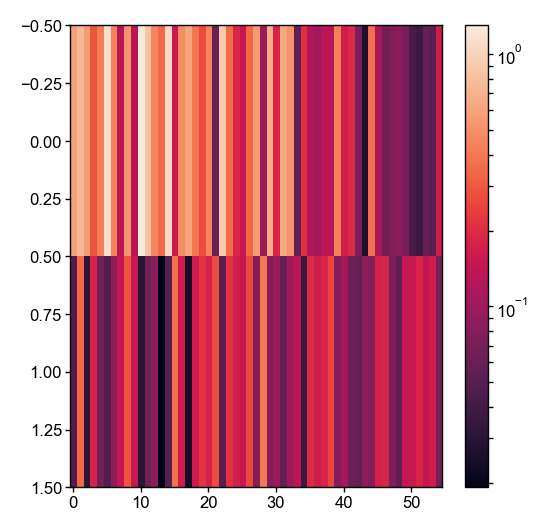

In [15]:
plt.imshow(mags.T, aspect='auto', norm="log")
plt.colorbar()

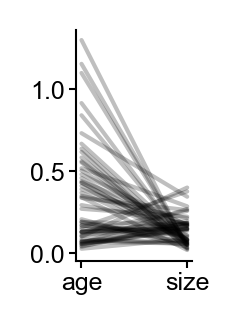

In [16]:
fig = figure(0.5, 1)
for line in mags:
    plt.plot([0, 1], line, c='k', alpha=0.25)
plt.xticks([0, 1], ["age", "size"])
sns.despine()

Text(0, 0.5, 'syllables')

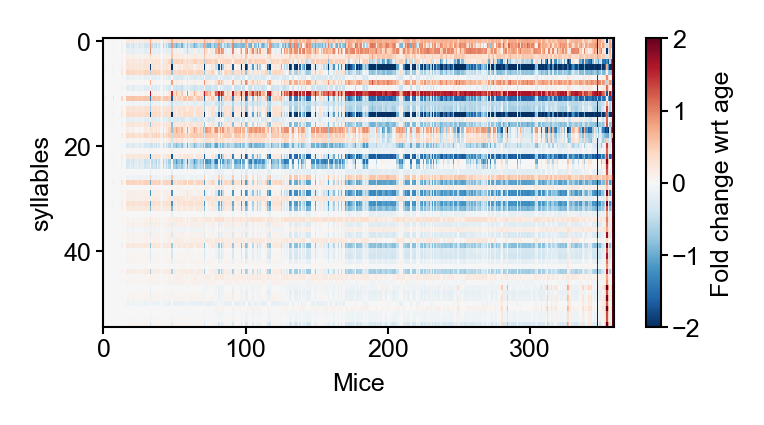

In [21]:
figure(2.75, 1.25)
mag = 2.0
plt.imshow(
    local_d[..., 0].T, vmin=-mag, vmax=mag, cmap="RdBu_r", aspect="auto", interpolation="none"
)
plt.colorbar(label="Fold change wrt age")
plt.xlabel("Mice")
plt.ylabel("syllables")

Text(0, 0.5, 'syllables')

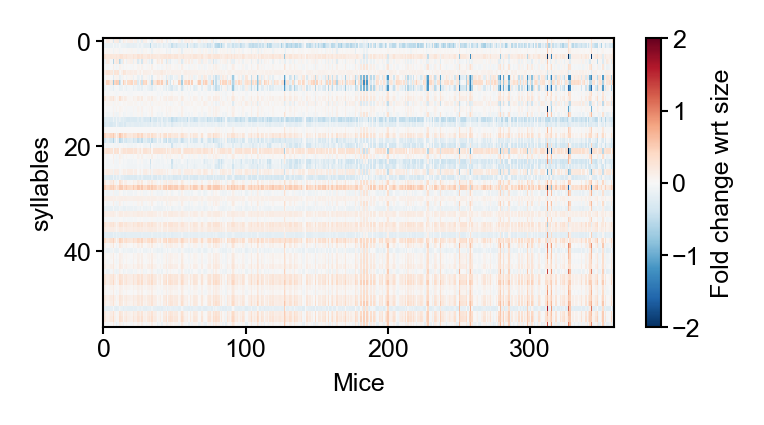

In [22]:
figure(2.75, 1.25)
plt.imshow(
    local_d[..., 1].T, vmin=-mag, vmax=mag, cmap="RdBu_r", aspect="auto", interpolation="none"
)
plt.colorbar(label="Fold change wrt size")
plt.xlabel("Mice")
plt.ylabel("syllables")

## Run for individuality

In [ ]:
# load longtogeny dataframe

# TODO: process size from longtogeny dataframe